# Accessing the project directory on my Google Drive  

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [2]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [3]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [4]:
folder = "tuning_data/"
experiment_num = 3
shuffle_batch = False

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [5]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.5 # for saving the best trained models 
max_epoch_num = 150 # max num of epoches 
train_acc_exit=0.9999 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.995 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [6]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_lstm_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

In [7]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.0
bidirectional = False
use_attention = True
reduction_method = torch.sum

learning_rate = 3e-1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.3245833694934843, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014564457385858986, 'overlap rate': 0.03233195497887209}
evaluation performance: {'loss': 3.3212984561920167, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001560476027225377, 'overlap rate': 0.038744845613837245}

Current epoch: 10, 
training performance: {'loss': 3.32315217256546, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0030190716657671145, 'overlap rate': 0.034991043678019196}
evaluation performance: {'loss': 3.313696503639221, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.002835594388307072, 'overlap rate': 0.040043494943529365}

Current epoch: 15, 
training performance: {'loss': 3.3260011315345763, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0030303179897600784, 'overlap rate': 0.03473422946408391}
evaluation performance: {'loss': 3.315935826301575, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 

KeyboardInterrupt: ignored

## Hyperparameter set 2


In [9]:
hidden_size = 128
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.24087099134922, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.06812100592069328, 'overlap rate': 0.33755025267601013}
evaluation performance: {'loss': 3.086911052465439, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.06899124826304615, 'overlap rate': 0.14491404183208942}

Current epoch: 10, 
training performance: {'loss': 3.087285029888153, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.05521257948130369, 'overlap rate': 0.1424029354006052}
evaluation performance: {'loss': 3.0627695500850676, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.06699211499653757, 'overlap rate': 0.12421720307320357}

Current epoch: 15, 
training performance: {'loss': 1.7507953643798828, 'abosulate accuracy': 0.006000000261701643, 'consecutive overlap rate': 0.1247596565168351, 'overlap rate': 0.5519432723522186}
evaluation performance: {'loss': 3.394793212413788, 'abosulate accuracy': 0.0010000000533182175, 'consecu

KeyboardInterrupt: ignored

# Hyperparameters set 3

In [11]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.549229401350021, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.027766083902679383, 'overlap rate': 0.2502598324790597}
evaluation performance: {'loss': 2.8820304393768312, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0359643328236416, 'overlap rate': 0.13593221697956323}

Current epoch: 10, 
training performance: {'loss': 1.9954123705625535, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.05908866296522319, 'overlap rate': 0.3869508311152458}
evaluation performance: {'loss': 2.797506594657898, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.07003366868011654, 'overlap rate': 0.1779670102521777}

Current epoch: 15, 
training performance: {'loss': 1.3347580388188363, 'abosulate accuracy': 0.00010000000474974513, 'consecutive overlap rate': 0.09102260968647898, 'overlap rate': 0.6132776409387588}
evaluation performance: {'loss': 3.2162621080875398, 'abosulate accuracy': 0.00020000000949949026, 'co

KeyboardInterrupt: ignored

# Hyperparameters set 4

In [15]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.781964731216431, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.010815834504319355, 'overlap rate': 0.18115700650960206}
evaluation performance: {'loss': 2.939820736646652, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.014209335122723132, 'overlap rate': 0.130989233776927}

Current epoch: 10, 
training performance: {'loss': 1.858187848329544, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.02514950216282159, 'overlap rate': 0.4121866635978222}
evaluation performance: {'loss': 2.6375386297702788, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.02737524772528559, 'overlap rate': 0.17336541116237641}

Current epoch: 15, 
training performance: {'loss': 1.5631407707929612, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.043103393912315366, 'overlap rate': 0.4960196420550346}
evaluation performance: {'loss': 2.636133450269699, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0498268016

KeyboardInterrupt: ignored

# Hyperparameters set 5

In [17]:
hidden_size = 128
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.929855686426163, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.008875835232902318, 'overlap rate': 0.140627496317029}
evaluation performance: {'loss': 3.0195991337299346, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.010298255283851176, 'overlap rate': 0.10735446475446224}

Current epoch: 10, 
training performance: {'loss': 2.2433258295059204, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01869861058657989, 'overlap rate': 0.31050349250435827}
evaluation performance: {'loss': 2.885783630609512, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01854435675777495, 'overlap rate': 0.12703361604362726}

Current epoch: 15, 
training performance: {'loss': 2.126531806588173, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.028118742059450596, 'overlap rate': 0.3573145713657141}
evaluation performance: {'loss': 2.8903679132461546, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.03011578

KeyboardInterrupt: ignored

# RedStr



In [19]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [20]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.0084290385246275, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0033206011954462155, 'overlap rate': 0.13638056702911855}
evaluation performance: {'loss': 3.012993943691254, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.003321599090122618, 'overlap rate': 0.13201529085636138}

Current epoch: 10, 
training performance: {'loss': 2.0803564161062242, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.015448299795389175, 'overlap rate': 0.3531089976429939}
evaluation performance: {'loss': 2.7404724597930907, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.008826284983661026, 'overlap rate': 0.15074477382004262}

Current epoch: 15, 
training performance: {'loss': 1.1049787804484368, 'abosulate accuracy': 0.0009000000427477062, 'consecutive overlap rate': 0.06655654176138341, 'overlap rate': 0.6650463536381721}
evaluation performance: {'loss': 3.025133031606674, 'abosulate accuracy': 0.0, 'consecutive ove

KeyboardInterrupt: ignored

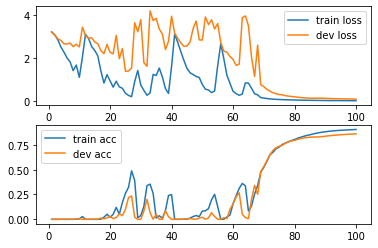

In [ ]:
plot_log(log)